# Data Analysis Project: Global Energy Usage
## Project Code
##### Nima Shafikhani

### Part 1: Preprocessing the Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import imageio.v2 as imageio
import geopandas as gpd
import geodatasets
import os

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
# Energy dataset
df = pd.read_csv('global-data-on-sustainable-energy.csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [3]:
# Continents dataset (will be using sub-regions)
continents = pd.read_csv('continents.csv')
continents.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [4]:
# Standardizing country names for proper merging
country_name_mapping_continents = {
    'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
    'Czech Republic': 'Czechia',
    'Guinea Bissau': 'Guinea-Bissau',
    'Macedonia': 'North Macedonia'
}
continents['name'] = continents['name'].replace(country_name_mapping_continents)

In [5]:
# Merge datasets
df = df.merge(continents[['name', 'sub-region']], left_on = ['Entity'], right_on = ['name'], how = 'left')
df.drop(columns=["name"], inplace=True)

In [6]:
# Merge was successful, all matches
df[df['sub-region'].isna()]

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude,sub-region


In [7]:
# Population dataset (will be using population to calculate total energy consumption)
population = pd.read_csv("population.csv", skiprows=4)

# Only keep country names and years 2000-2020
cols_to_drop = []
for col in population.columns[1:]:
    try:
        year = int(col)
        if year not in range(2000, 2021):
            cols_to_drop.append(col)
    except ValueError:
        cols_to_drop.append(col)

population.drop(columns = cols_to_drop,
                inplace = True)

population.head()

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,90588.0,91439.0,92074.0,93128.0,95138.0,97635.0,99405.0,100150.0,100917.0,101604.0,101838.0,102591.0,104110.0,105675.0,106807.0,107906.0,108727.0,108735.0,108908.0,109203.0,108587.0
1,Africa Eastern and Southern,406156661.0,416807868.0,427820358.0,439173286.0,450928044.0,463076637.0,475606210.0,488580707.0,502070763.0,516003448.0,530308387.0,544737983.0,559609961.0,575202699.0,590968990.0,607123269.0,623369401.0,640058741.0,657801085.0,675950189.0,694446100.0
2,Afghanistan,20130327.0,20284307.0,21378117.0,22733049.0,23560654.0,24404567.0,25424094.0,25909852.0,26482622.0,27466101.0,28284089.0,29347708.0,30560034.0,31622704.0,32792523.0,33831764.0,34700612.0,35688935.0,36743039.0,37856121.0,39068979.0
3,Africa Western and Central,274968446.0,282780717.0,290841795.0,299142845.0,307725100.0,316588476.0,325663158.0,334984176.0,344586109.0,354343844.0,364358270.0,374790143.0,385360349.0,396030207.0,406992047.0,418127845.0,429454743.0,440882906.0,452195915.0,463365429.0,474569351.0
4,Angola,16194869.0,16747208.0,17327699.0,17943712.0,18600423.0,19291161.0,20015279.0,20778561.0,21578655.0,22414773.0,23294825.0,24218352.0,25177394.0,26165620.0,27160769.0,28157798.0,29183070.0,30234839.0,31297155.0,32375632.0,33451132.0


In [8]:
# Datasets had some differences in country names, cleaned up
country_name_mapping = {
    'Yemen, Rep.': 'Yemen',
    'Turkiye': 'Turkey',
    'Slovak Republic': 'Slovakia',
    'Bahamas, The': 'Bahamas',
    'Congo, Dem. Rep.': 'Congo',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines'  
}

population['Country Name'] = population['Country Name'].replace(country_name_mapping)

In [9]:
# Making data long format
population = population.melt(id_vars=["Country Name"], var_name="Year", value_name="Population")
population.head()

,Country Name,Year,Population
0,Aruba,2000,90588.0
1,Africa Eastern and Southern,2000,406156661.0
2,Afghanistan,2000,20130327.0
3,Africa Western and Central,2000,274968446.0
4,Angola,2000,16194869.0


In [10]:
# Merge the energy and population data
population["Year"] = population["Year"].astype(int)
df = df.merge(population, left_on=["Entity", "Year"], right_on=["Country Name", "Year"], how="left")

# Drop the redundant 'Country Name' column after merging
df.drop(columns=["Country Name"], inplace=True)

df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude,sub-region,Population
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20130327.0
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20284307.0
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953,Southern Asia,21378117.0
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953,Southern Asia,22733049.0
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953,Southern Asia,23560654.0


In [11]:
# Merge was successful except for one entity with no match
df[df['Population'].isna()]

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude,sub-region,Population
1218,French Guiana,2000,NaN,NaN,702.29,NaN,23.84,0.43,0.0,0.0,0.0,13692.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latin America and the Caribbean,NaN


In [12]:
# French Guiana can be dropped, only one instance and missing lots of data
df.drop(index=1218, inplace=True)

In [13]:
df.shape

(3648, 23)

In [14]:
df.describe()

,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Land Area(Km2),Latitude,Longitude,Population
count,3648.000000,3639.000000,3480.000000,2717.000000,1.560000e+03,3454.000000,3627.000000,3522.000000,3627.000000,3606.000000,3648.000000,3442.000000,3.221000e+03,1512.000000,3332.000000,3367.000000,3.648000e+03,3648.000000,3648.000000,3.648000e+03
mean,2010.041118,78.933702,63.255287,112.920659,9.422400e+07,32.640712,70.384285,13.454009,23.974618,36.811387,25747.285360,5.307345,1.598665e+05,11.986707,3.441610,13283.774348,6.332135e+05,18.246388,14.822695,3.704844e+07
std,6.052776,30.275541,39.043658,243.950310,2.981544e+08,29.898855,348.097919,73.016638,104.444726,34.314168,34777.415694,3.532020,7.736611e+05,14.994644,5.686720,19709.866716,1.585519e+06,24.159232,66.348148,1.423804e+08
min,2000.000000,1.252269,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,1.000000e+01,0.000000,-62.075920,111.927225,2.100000e+01,-40.900557,-175.198242,9.544000e+03
25%,2005.000000,59.800890,23.175000,3.540000,2.600000e+05,6.512500,0.290000,0.000000,0.040000,2.899582,3116.636825,3.170000,2.020000e+03,2.137095,1.383302,1337.813437,2.571300e+04,3.202778,-11.779889,1.925652e+06
50%,2010.000000,98.361570,83.150000,32.880000,5.665000e+06,23.275000,2.970000,0.000000,1.470000,27.907607,13118.841000,4.300000,1.050000e+04,6.290766,3.559855,4578.633208,1.176000e+05,17.189877,19.145136,7.294240e+06
75%,2015.000000,100.000000,100.000000,112.090000,5.534750e+07,55.247500,26.845000,0.000000,9.600000,64.424116,33897.402500,6.027500,6.058000e+04,16.841638,5.830099,15768.615365,5.131200e+05,38.969719,46.199616,2.239750e+07
max,2020.000000,100.000000,100.000000,3060.190000,5.202310e+09,96.040000,5184.130000,809.410000,2184.940000,100.000010,262585.700000,32.570000,1.070722e+07,86.836586,123.139555,123514.196700,9.984670e+06,64.963051,178.065032,1.411100e+09


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3648 entries, 0 to 3648
Data columns (total 23 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3648 non-null   object 
 1   Year                                                              3648 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2717 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3454 non-null   float64
 7   Electricity from fossil fuels (TWh)   

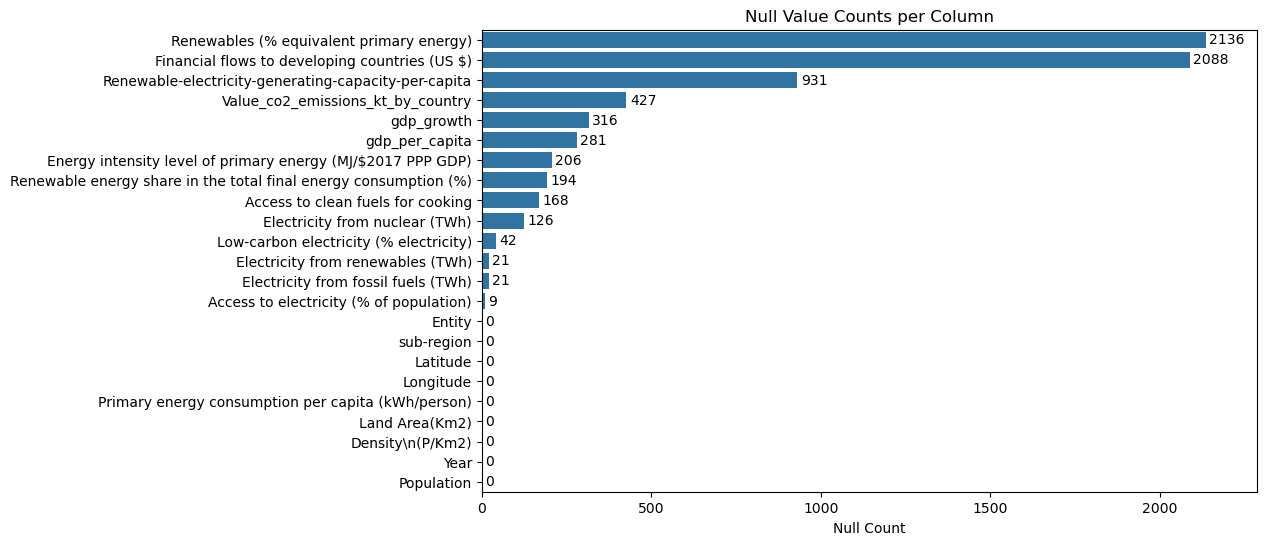

In [16]:
# Visualize null counts by column
null_counts = df.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts, 
            y=null_counts.index, 
            orient='h')
plt.xlabel('Null Count')
plt.ylabel(None)
plt.xlim(0, null_counts.max() + 150)
for i, value in enumerate(null_counts):
    plt.text(value + 10, i, f'{value}', va='center', ha='left', fontsize=10)
plt.title("Null Value Counts per Column")
plt.show()

In [17]:
# Not all countries have financial inflow for growth
# Other columns with major null rates are not going to be used for analysis, drop
df.drop(columns = ['Renewables (% equivalent primary energy)',
                  'Renewable-electricity-generating-capacity-per-capita',
                  'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'],
       inplace = True)
# Also removed other rows that I know I won't be using
# I will consider the rest of the rows

### Part 2: Visualization

**Question 1**: How do the sources of electricity and their contributing percentages to overall electricity demand differ among countries when categorized by GDP per capita, and what is the general state of electricity and overall energy access within these GDP buckets? <br>

In [18]:
# Classifying country based on income using GDP per capita
# SOURCE: https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

income_thresholds = {}

income_thresholds[2000] = {'Low Income': 755,
                           'Lower-Middle Income': 2995,
                           'Upper-Middle Income': 9265}
income_thresholds[2001] = {'Low Income': 745,
                           'Lower-Middle Income': 2975,
                           'Upper-Middle Income': 9205}
income_thresholds[2002] = {'Low Income': 735,
                           'Lower-Middle Income': 2935,
                           'Upper-Middle Income': 9075}
income_thresholds[2003] = {'Low Income': 765,
                           'Lower-Middle Income': 3035,
                           'Upper-Middle Income': 9385}
income_thresholds[2004] = {'Low Income': 825,
                           'Lower-Middle Income': 3255,
                           'Upper-Middle Income': 10065}
income_thresholds[2005] = {'Low Income': 875,
                           'Lower-Middle Income': 3465,
                           'Upper-Middle Income': 10725}
income_thresholds[2006] = {'Low Income': 905,
                           'Lower-Middle Income': 3595,
                           'Upper-Middle Income': 11115}
income_thresholds[2007] = {'Low Income': 935,
                           'Lower-Middle Income': 3705,
                           'Upper-Middle Income': 11455}
income_thresholds[2008] = {'Low Income': 975,
                           'Lower-Middle Income': 3855,
                           'Upper-Middle Income': 11905}
income_thresholds[2009] = {'Low Income': 995,
                           'Lower-Middle Income': 3945,
                           'Upper-Middle Income': 12195}
income_thresholds[2010] = {'Low Income': 1005,
                           'Lower-Middle Income': 3975,
                           'Upper-Middle Income': 12275}
income_thresholds[2011] = {'Low Income': 1025,
                           'Lower-Middle Income': 4035,
                           'Upper-Middle Income': 12475}
income_thresholds[2012] = {'Low Income': 1035,
                           'Lower-Middle Income': 4085,
                           'Upper-Middle Income': 12615}
income_thresholds[2013] = {'Low Income': 1045,
                           'Lower-Middle Income': 4125,
                           'Upper-Middle Income': 12745}
income_thresholds[2014] = {'Low Income': 1045,
                           'Lower-Middle Income': 4125,
                           'Upper-Middle Income': 12735}
income_thresholds[2015] = {'Low Income': 1025,
                           'Lower-Middle Income': 4035,
                           'Upper-Middle Income': 12475}
income_thresholds[2016] = {'Low Income': 1005,
                           'Lower-Middle Income': 3955,
                           'Upper-Middle Income': 12235}
income_thresholds[2017] = {'Low Income': 995,
                           'Lower-Middle Income': 3895,
                           'Upper-Middle Income': 12055}
income_thresholds[2018] = {'Low Income': 1025,
                           'Lower-Middle Income': 3995,
                           'Upper-Middle Income': 12375}
income_thresholds[2019] = {'Low Income': 1035,
                           'Lower-Middle Income': 4045,
                           'Upper-Middle Income': 12535}
income_thresholds[2020] = {'Low Income': 1045,
                           'Lower-Middle Income': 4095,
                           'Upper-Middle Income': 12695}

def classify_income(row):
    '''
    Using the income thresholds dictionary
    Classify each country by its income bracket
    Using World Bank Data
    '''
    year = row['Year']
    gdp = row['gdp_per_capita']
    
    if gdp <= income_thresholds[year]['Low Income']:
        return 'Low Income'
    elif gdp <= income_thresholds[year]['Lower-Middle Income']:
        return 'Lower-Middle Income'
    elif gdp <= income_thresholds[year]['Upper-Middle Income']:
        return 'Upper-Middle Income'
    elif gdp > income_thresholds[year]['Upper-Middle Income']:
        return 'High Income'
    else:
        return None

df['income_bracket'] = df.apply(classify_income, axis = 1)
income_order = ['High Income', 'Upper-Middle Income', 'Lower-Middle Income','Low Income']
df['income_bracket'] = pd.Categorical(df['income_bracket'], categories=income_order, ordered=True)

In [19]:
df['total_energy_usage_kwh'] = df['Primary energy consumption per capita (kWh/person)'] * df['Population']

In [20]:
# Color palette to distinguish income brackets
custom_palette = {
    'Low Income': '#E74C3C',
    'Lower-Middle Income': '#F39C12',
    'Upper-Middle Income': '#2ECC71',
    'High Income': '#2980B9'
}

#### Access to Electricity by Income Bracket

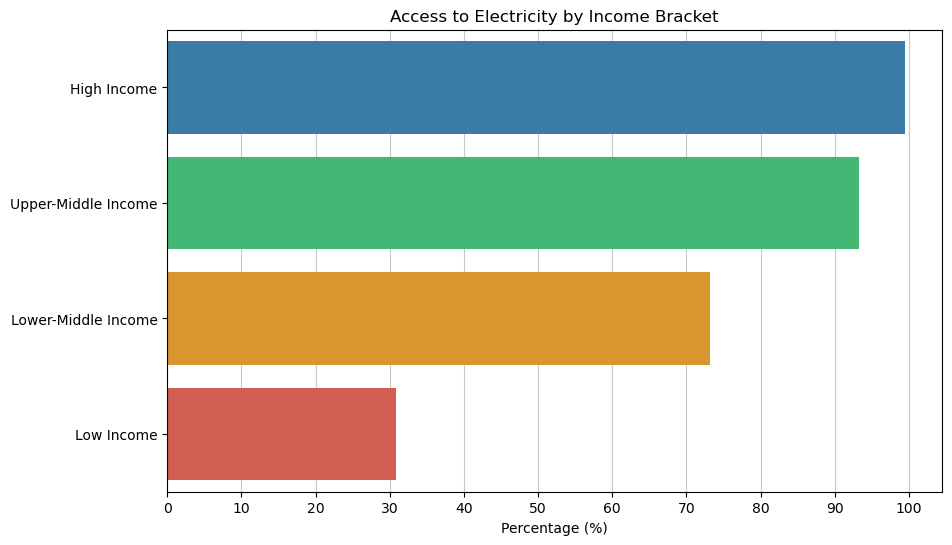

In [21]:
plt.figure(figsize = (10, 6))
sns.barplot(y='income_bracket', 
            x='Access to electricity (% of population)', 
            orient='h', 
            errorbar=None, 
            data=df,
            palette=custom_palette,
            hue='income_bracket',
            zorder=2)

plt.title('Access to Electricity by Income Bracket')
plt.xlabel('Percentage (%)')
plt.ylabel(None)
plt.xticks(ticks=range(0, 101, 10))
plt.grid(True, axis='x', alpha=0.7, zorder=0)
plt.legend().set_visible(False)

plt.show()

#### Total Energy Consumption

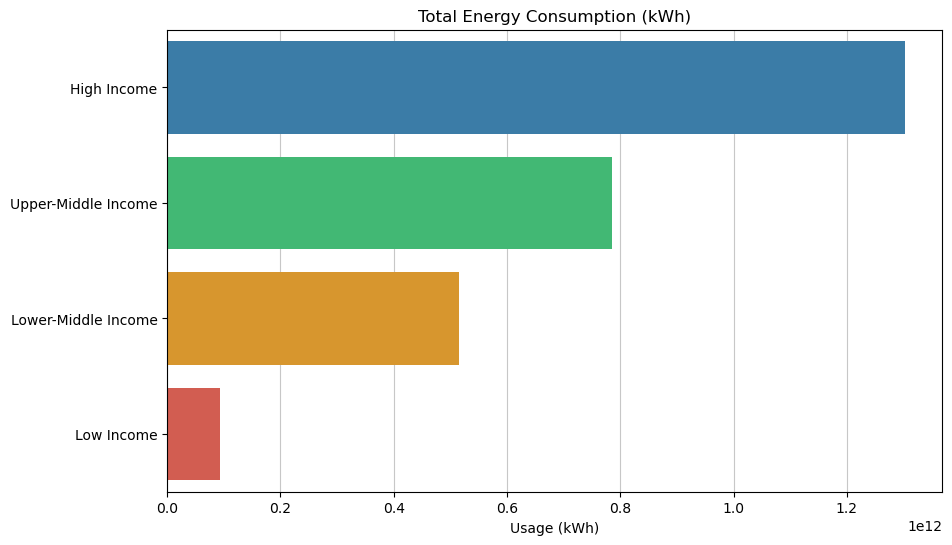

In [22]:
plt.figure(figsize = (10, 6))
sns.barplot(y='income_bracket', 
            x='total_energy_usage_kwh', 
            orient='h', 
            errorbar=None, 
            data=df,
            palette=custom_palette,
            hue='income_bracket',
            zorder=2)

plt.title('Total Energy Consumption (kWh)')
plt.xlabel('Usage (kWh)')
plt.ylabel(None)
plt.grid(True, axis='x', alpha=0.7, zorder=0)
plt.legend().set_visible(False)

plt.show() 

#### Energy Consumption Per Capita (kWh/person)

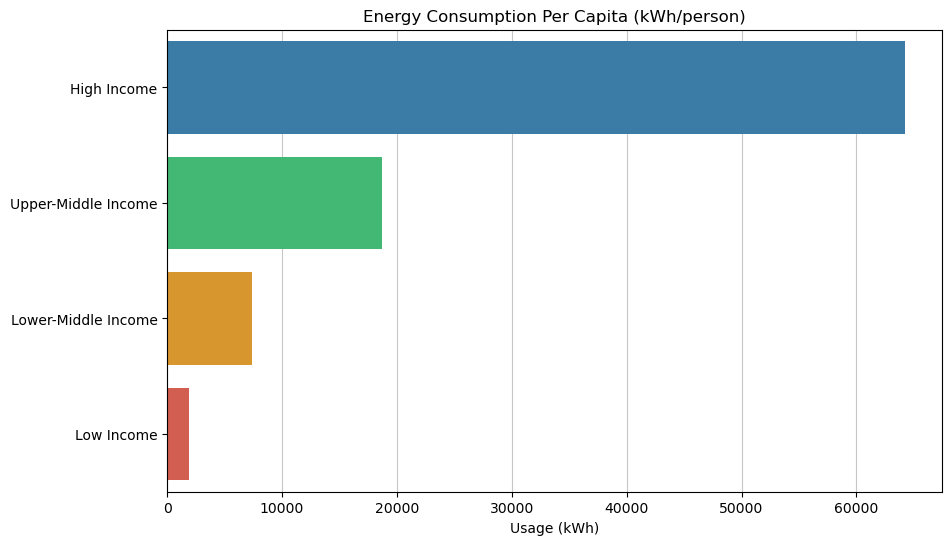

In [23]:
plt.figure(figsize = (10, 6))
sns.barplot(y='income_bracket', 
            x='Primary energy consumption per capita (kWh/person)', 
            orient='h', 
            errorbar=None, 
            data=df,
            palette=custom_palette,
            hue='income_bracket',
            zorder=2)

plt.title('Energy Consumption Per Capita (kWh/person)')
plt.xlabel('Usage (kWh)')
plt.ylabel(None)
plt.grid(True, axis='x', alpha=0.7, zorder=0)
plt.legend().set_visible(False)

plt.show()

#### Renewable Energy Share in Total Energy Consumption (%)

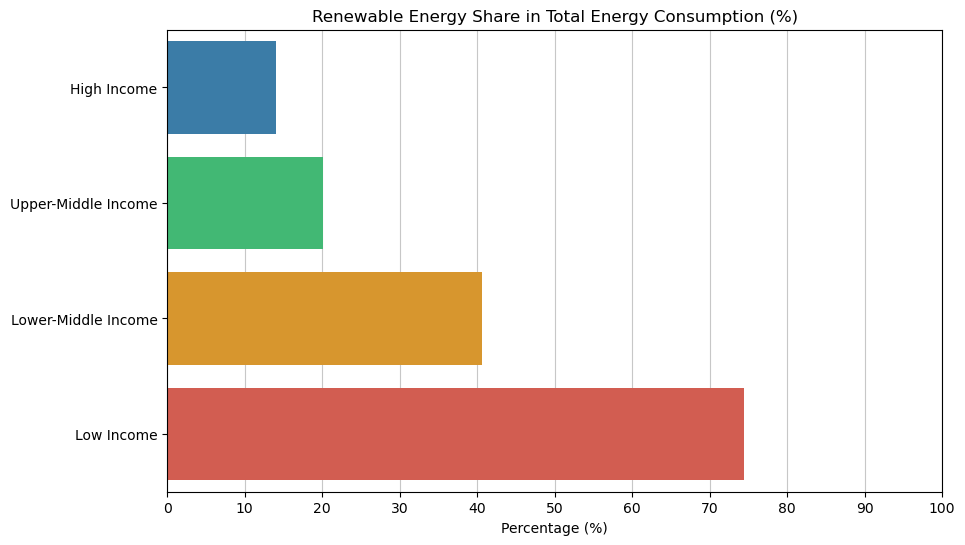

In [24]:
plt.figure(figsize = (10, 6))
sns.barplot(y='income_bracket', 
            x='Renewable energy share in the total final energy consumption (%)', 
            orient='h', 
            errorbar=None, 
            data=df,
            palette=custom_palette,
            hue='income_bracket',
            zorder=2)

plt.title('Renewable Energy Share in Total Energy Consumption (%)')
plt.xlabel('Percentage (%)')
plt.ylabel(None)
plt.xticks(ticks=range(0, 101, 10))
plt.grid(True, axis='x', alpha=0.7, zorder=0)
plt.legend().set_visible(False)

plt.show()

#### Electricity Usage Total, By Income Bracket

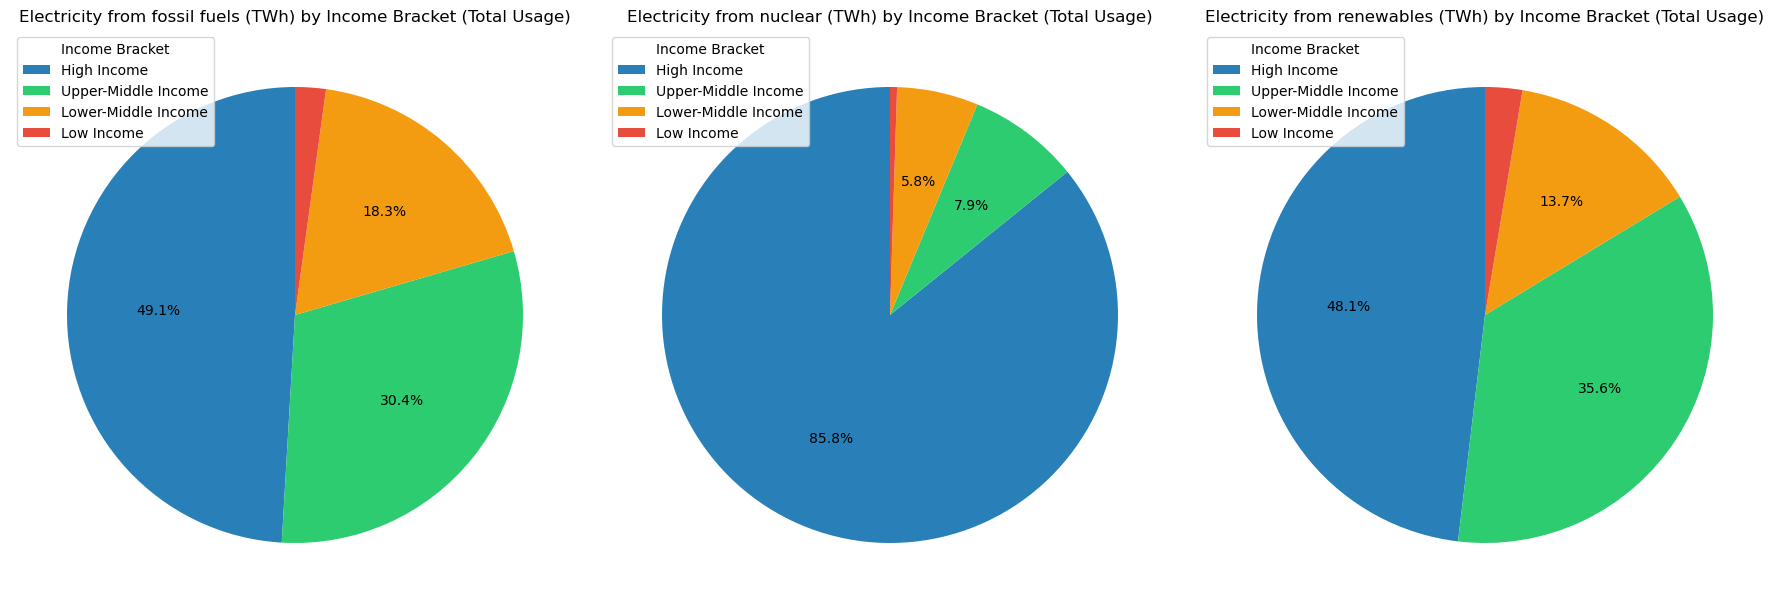

In [25]:
income_energy_sources = df.groupby('income_bracket', observed=True)[['Electricity from fossil fuels (TWh)', 
                                                                   'Electricity from nuclear (TWh)', 
                                                                   'Electricity from renewables (TWh)']].sum().reset_index()

def custom_autopct(pct):
    return f'{pct:.1f}%' if pct > 3 else ''

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

energy_sources = ['Electricity from fossil fuels (TWh)', 
                  'Electricity from nuclear (TWh)', 
                  'Electricity from renewables (TWh)']

for i, energy in enumerate(energy_sources):
    total_usage = income_energy_sources[energy].sum()
    usage_by_income_bracket = income_energy_sources[energy]
    percentages = usage_by_income_bracket / total_usage * 100    
    wedges, texts, autotexts = axes[i].pie(percentages, 
                                           autopct=lambda pct: custom_autopct(pct), 
                                           colors=[custom_palette[bracket] for bracket in income_energy_sources['income_bracket']],
                                           startangle=90)
    
    axes[i].set_title(f'{energy} by Income Bracket (Total Usage)')
    axes[i].legend(wedges, income_energy_sources['income_bracket'], title="Income Bracket")  
    
        
plt.tight_layout()

plt.show()


#### Electricity Usage Makeup Across Different Sources

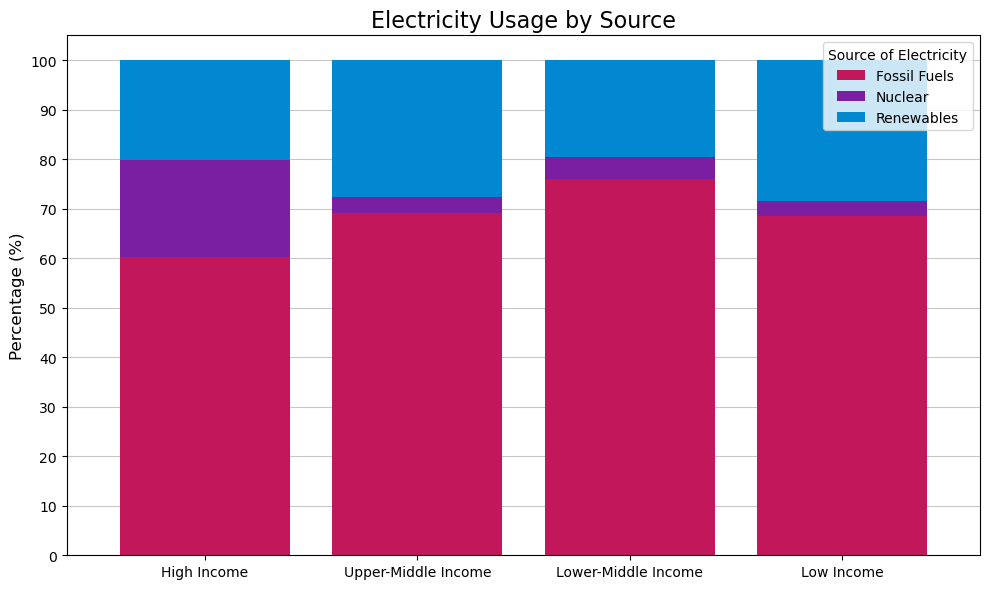

In [26]:
energy_source_colors = {
    'Electricity from fossil fuels (TWh)': '#C2185B',
    'Electricity from nuclear (TWh)': '#7B1FA2',
    'Electricity from renewables (TWh)': '#0288D1'
}

agg_df = df.groupby('income_bracket', observed=True)[['Electricity from fossil fuels (TWh)', 
                                                      'Electricity from nuclear (TWh)', 
                                                      'Electricity from renewables (TWh)']].sum()

agg_df_normalized = agg_df.div(agg_df.sum(axis=1), axis=0) * 100
agg_df_normalized = agg_df_normalized.reset_index()

agg_df_normalized.plot(kind='bar', 
                       stacked=True, 
                       x='income_bracket', 
                       figsize=(10, 6), 
                       color=list(energy_source_colors.values()), 
                       width=0.8,
                       zorder=2)

plt.title('Electricity Usage by Source', fontsize=16)
plt.xlabel(None)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Source of Electricity', labels=['Fossil Fuels', 'Nuclear', 'Renewables'])
plt.tight_layout()
plt.yticks(ticks=range(0, 101, 10))
plt.grid(True, axis='y', alpha=0.7, zorder=0)
plt.show()

**Question 2**: When observing regional trends, how have preferences or dependencies on types of electricity supply evolved over time?

In [27]:
sub_region_energy_sources = df.groupby(['sub-region', 'Year'], observed=True)[['Electricity from fossil fuels (TWh)', 
                                                                   'Electricity from nuclear (TWh)', 
                                                                   'Electricity from renewables (TWh)']].sum().reset_index()

sub_region_energy_sources.head()

,sub-region,Year,Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh)
0,Australia and New Zealand,2000,191.74,0.0,44.62
1,Australia and New Zealand,2001,207.84,0.0,42.24
2,Australia and New Zealand,2002,208.68,0.0,45.42
3,Australia and New Zealand,2003,207.75,0.0,45.40
4,Australia and New Zealand,2004,214.57,0.0,50.02


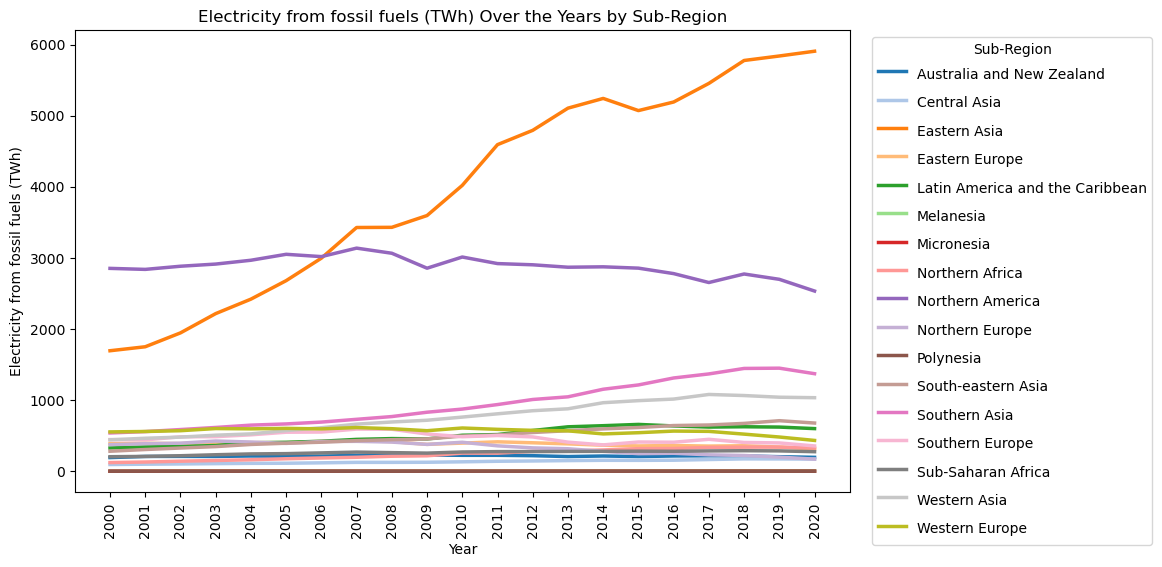

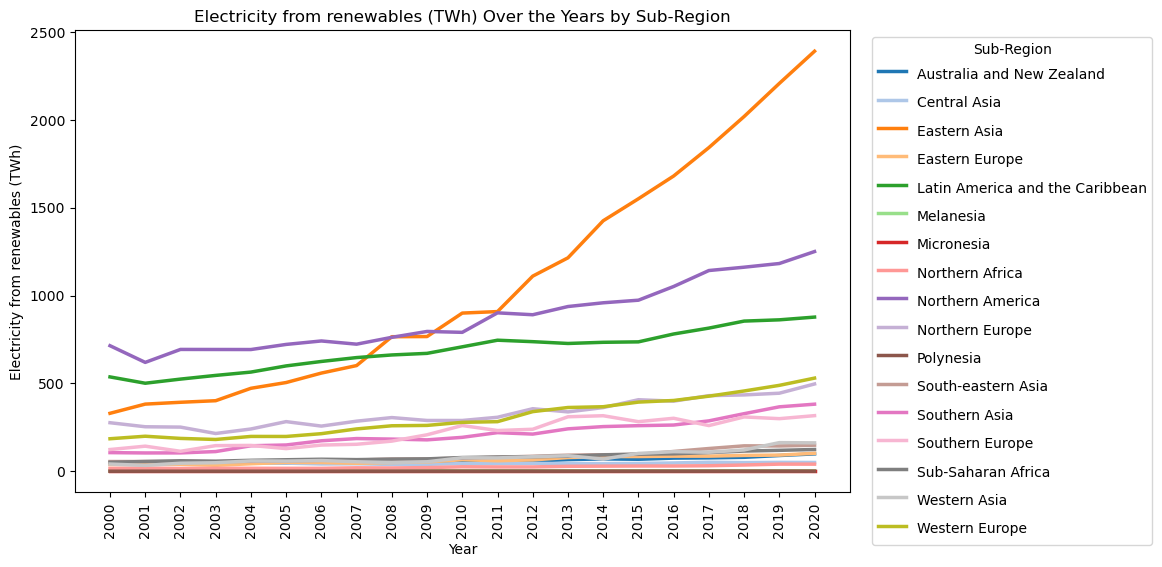

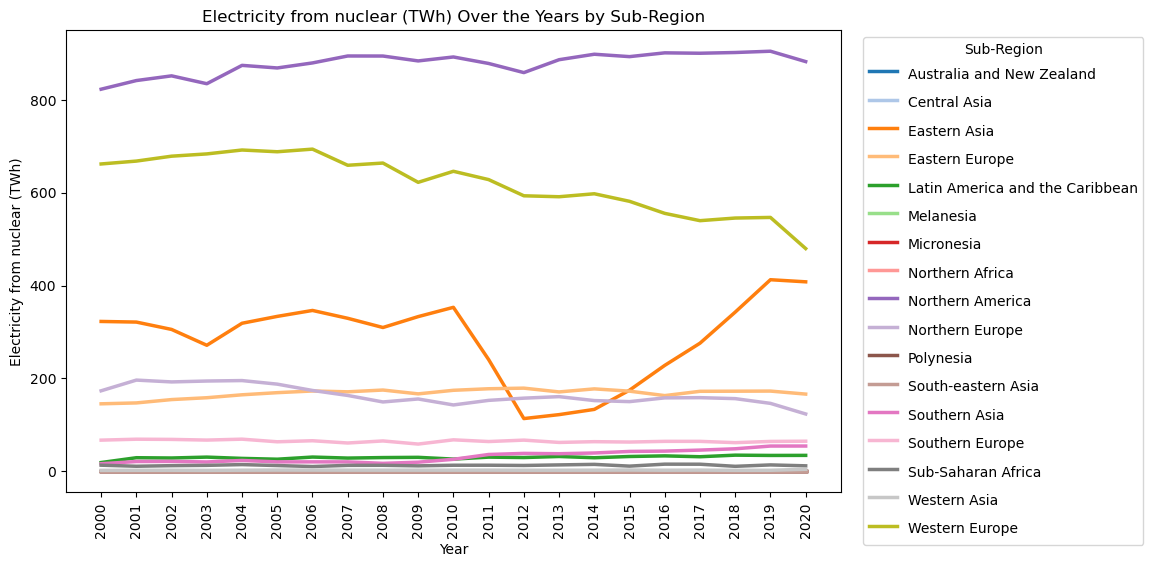

In [28]:
# List of energy sources to loop through
energy_sources = [
    'Electricity from fossil fuels (TWh)',
    'Electricity from renewables (TWh)',
    'Electricity from nuclear (TWh)'
]

for energy_source in energy_sources:
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=sub_region_energy_sources,
                 x='Year',
                 y=energy_source,
                 hue='sub-region',
                 linewidth=2.5,
                 palette='tab20')

    plt.legend(title='Sub-Region', bbox_to_anchor=(1.02, 1), loc='upper left', handleheight=2, handlelength=2, markerscale=1.5)
    plt.xticks(ticks=range(2000, 2021), rotation=90) 
    plt.title(f'{energy_source} Over the Years by Sub-Region')
    plt.show()


**Question 3**: In developing nations, is there a significant relationship between financial inflows (with the intent of increasing renewable energy usage) and the adoption of renewable and clean energy sources, and how does this impact their energy landscape and developmental trajectory?

In [29]:
# Find country, year pairs that received financial support

df['Electricity from nuclear (TWh)'] = df['Electricity from nuclear (TWh)'].fillna(0)

df['electricity_usage_total'] = \
    df['Electricity from renewables (TWh)'] + \
    df['Electricity from fossil fuels (TWh)'] + \
    df['Electricity from nuclear (TWh)']

df['renewable_share'] = \
    df['Electricity from renewables (TWh)'] \
    / df['electricity_usage_total']

financial_inflows_df = \
    df.copy()[df['Financial flows to developing countries (US $)'].notna()]\
        [['Entity', 
          'Year', 
          'Electricity from renewables (TWh)', 
          'Electricity from nuclear (TWh)', 
          'Electricity from fossil fuels (TWh)',
          'electricity_usage_total',
          'renewable_share',
          'Financial flows to developing countries (US $)']]

financial_inflows_df['next_year'] = financial_inflows_df['Year'] + 1
financial_inflows_df = financial_inflows_df.merge(df[['Entity', 
                                                        'Year', 
                                                        'Electricity from renewables (TWh)', 
                                                        'Electricity from nuclear (TWh)', 
                                                        'Electricity from fossil fuels (TWh)', 
                                                        'electricity_usage_total', 
                                                        'renewable_share']],
                                                  left_on = ['Entity', 'next_year'],
                                                  right_on = ['Entity', 'Year'],
                                                  how = 'left',
                                                  suffixes=('', '_next_year'))
financial_inflows_df.drop(columns = 'Year_next_year', inplace = True)
financial_inflows_df.head()

,Entity,Year,Electricity from renewables (TWh),Electricity from nuclear (TWh),Electricity from fossil fuels (TWh),electricity_usage_total,renewable_share,Financial flows to developing countries (US $),next_year,Electricity from renewables (TWh)_next_year,Electricity from nuclear (TWh)_next_year,Electricity from fossil fuels (TWh)_next_year,electricity_usage_total_next_year,renewable_share_next_year
0,Afghanistan,2000,0.31,0.0,0.16,0.47,0.659574,20000.0,2001,0.50,0.0,0.09,0.59,0.847458
1,Afghanistan,2001,0.50,0.0,0.09,0.59,0.847458,130000.0,2002,0.56,0.0,0.13,0.69,0.811594
2,Afghanistan,2002,0.56,0.0,0.13,0.69,0.811594,3950000.0,2003,0.63,0.0,0.31,0.94,0.670213
3,Afghanistan,2003,0.63,0.0,0.31,0.94,0.670213,25970000.0,2004,0.56,0.0,0.33,0.89,0.629213
4,Afghanistan,2005,0.59,0.0,0.34,0.93,0.634409,9830000.0,2006,0.64,0.0,0.20,0.84,0.761905


In [30]:
financial_inflows_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Entity                                          1560 non-null   object 
 1   Year                                            1560 non-null   int64  
 2   Electricity from renewables (TWh)               1550 non-null   float64
 3   Electricity from nuclear (TWh)                  1560 non-null   float64
 4   Electricity from fossil fuels (TWh)             1550 non-null   float64
 5   electricity_usage_total                         1550 non-null   float64
 6   renewable_share                                 1550 non-null   float64
 7   Financial flows to developing countries (US $)  1560 non-null   float64
 8   next_year                                       1560 non-null   int64  
 9   Electricity from renewables (TWh)_next_ye

In [31]:
financial_inflows_df['electricity_from_renewables_net_change_next_year'] = financial_inflows_df['Electricity from renewables (TWh)_next_year'] - financial_inflows_df['Electricity from renewables (TWh)']
financial_inflows_df.tail()

,Entity,Year,Electricity from renewables (TWh),Electricity from nuclear (TWh),Electricity from fossil fuels (TWh),electricity_usage_total,renewable_share,Financial flows to developing countries (US $),next_year,Electricity from renewables (TWh)_next_year,Electricity from nuclear (TWh)_next_year,Electricity from fossil fuels (TWh)_next_year,electricity_usage_total_next_year,renewable_share_next_year,electricity_from_renewables_net_change_next_year
1555,Zimbabwe,2016,3.32,0.0,3.50,6.82,0.486804,30000.0,2017,4.30,0.0,3.05,7.35,0.585034,0.98
1556,Zimbabwe,2017,4.30,0.0,3.05,7.35,0.585034,5570000.0,2018,5.46,0.0,3.73,9.19,0.594124,1.16
1557,Zimbabwe,2018,5.46,0.0,3.73,9.19,0.594124,10000.0,2019,4.58,0.0,3.66,8.24,0.555825,-0.88
1558,Zimbabwe,2019,4.58,0.0,3.66,8.24,0.555825,250000.0,2020,4.19,0.0,3.40,7.59,0.552042,-0.39
1559,Zimbabwe,2020,4.19,0.0,3.40,7.59,0.552042,30000.0,2021,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Calculate the average for each column across all countries for each year
df_avg = financial_inflows_df[['next_year',
                               'Electricity from renewables (TWh)_next_year', 
                               'renewable_share',
                               'electricity_from_renewables_net_change_next_year']].groupby('next_year').mean().reset_index()

df_avg_2000 = financial_inflows_df[financial_inflows_df['Year'] == 2000] \
                 [['Year',
                   'Electricity from renewables (TWh)', 
                   'renewable_share']].groupby('Year').mean().reset_index()
df_avg_2000['electricity_from_renewables_net_change'] = np.nan


df_avg.columns = ['Year',
                  'Electricity from renewables (TWh)',
                  'renewable_share',
                  'electricity_from_renewables_net_change']

In [33]:
df_avg_2000

,Year,Electricity from renewables (TWh),renewable_share,electricity_from_renewables_net_change
0,2000,17.44098,0.450618,NaN


In [34]:
df_avg

,Year,Electricity from renewables (TWh),renewable_share,electricity_from_renewables_net_change
0,2001,17.720588,0.450618,0.279608
1,2002,19.819608,0.400542,0.838039
2,2003,19.041000,0.387105,0.408800
3,2004,21.770769,0.487078,2.421346
4,2005,21.074237,0.421665,1.383220
5,2006,21.393906,0.425605,1.484219
6,2007,22.998358,0.436917,1.269403
7,2008,24.857121,0.394807,2.597576
8,2009,24.409701,0.396518,0.144478
9,2010,24.590633,0.409888,2.652405


In [35]:
df_avg.drop(index = 20, inplace = True)
df_avg = pd.concat([df_avg_2000, df_avg], axis = 0)
df_avg

,Year,Electricity from renewables (TWh),renewable_share,electricity_from_renewables_net_change
0,2000,17.440980,0.450618,NaN
0,2001,17.720588,0.450618,0.279608
1,2002,19.819608,0.400542,0.838039
2,2003,19.041000,0.387105,0.408800
3,2004,21.770769,0.487078,2.421346
4,2005,21.074237,0.421665,1.383220
5,2006,21.393906,0.425605,1.484219
6,2007,22.998358,0.436917,1.269403
7,2008,24.857121,0.394807,2.597576
8,2009,24.409701,0.396518,0.144478


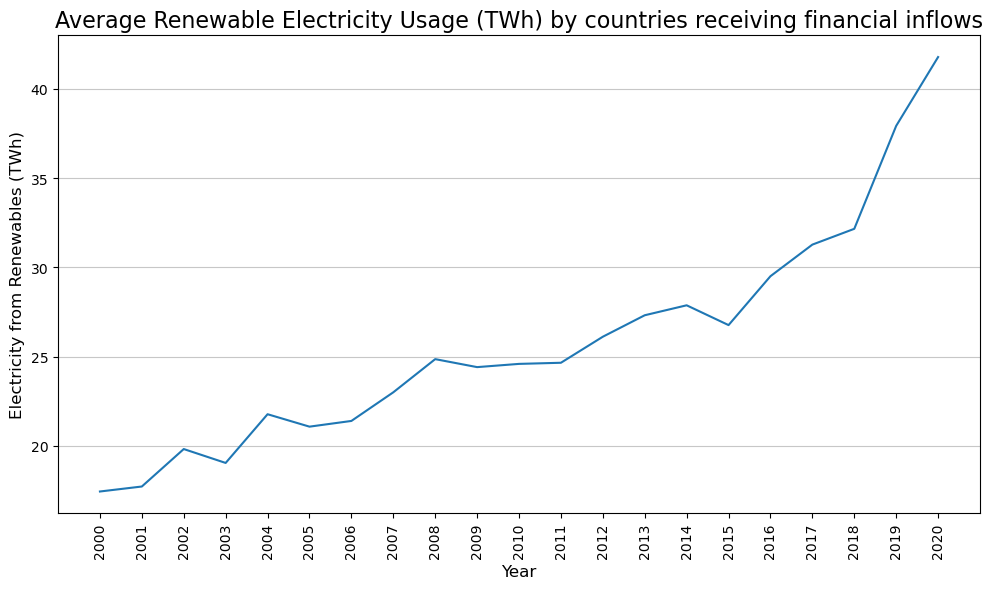

In [36]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, 
             x='Year', 
             y='Electricity from renewables (TWh)')
plt.title('Average Renewable Electricity Usage (TWh) by countries receiving financial inflows',
          fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Electricity from Renewables (TWh)', fontsize=12)
plt.xticks(ticks=range(2000, 2021), rotation=90)  # Set x-ticks and rotate labels
plt.grid(False)
plt.tight_layout()
plt.grid(axis='y', alpha=0.7)

plt.show()

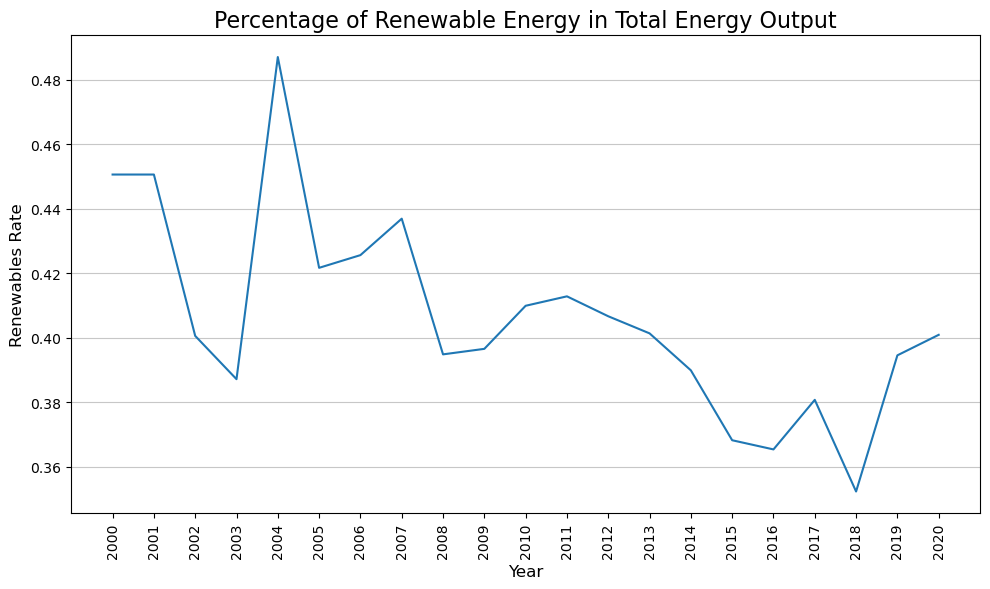

In [48]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, 
             x='Year', 
             y='renewable_share')
plt.title('Percentage of Renewable Energy in Total Energy Output',
          fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Renewables Rate', fontsize=12)
plt.xticks(ticks=range(2000, 2021), rotation=90)  # Set x-ticks and rotate labels
plt.grid(False)
plt.tight_layout()
plt.grid(axis='y', alpha=0.7)

plt.show()

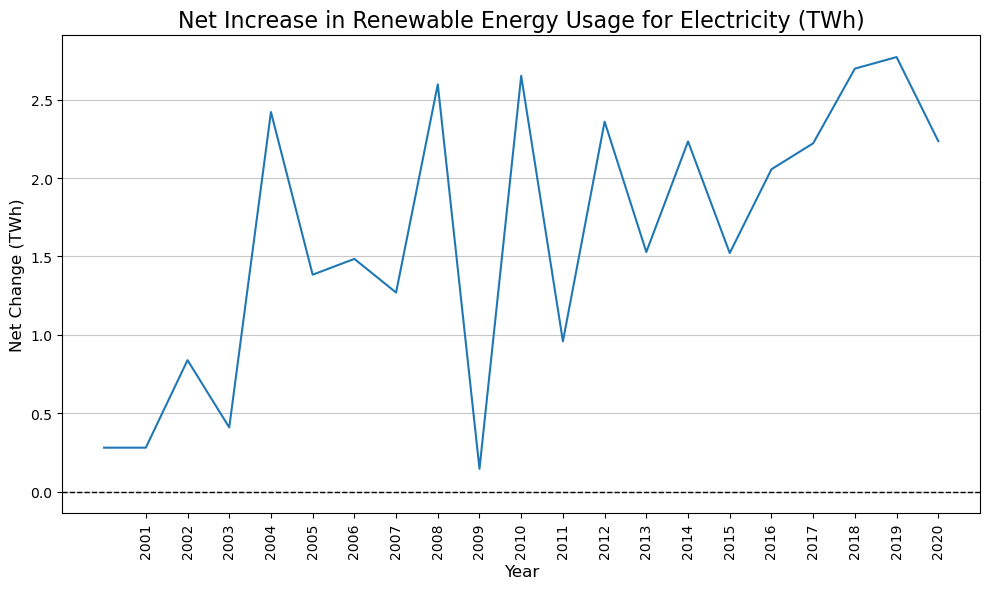

In [49]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg, 
             x='Year', 
             y='electricity_from_renewables_net_change')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Net Increase in Renewable Energy Usage for Electricity (TWh)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Net Change (TWh)', fontsize=12)
plt.xticks(ticks=range(2001, 2021), rotation=90)
plt.grid(False)
plt.tight_layout()
plt.grid(axis='y', alpha=0.7)

plt.show()

**Question 4**: How do CO₂ emissions vary by income bracket? Which regions have contributed the most CO₂ emissions, and which have experienced the highest growth in emissions?

In [39]:
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude,sub-region,Population,income_bracket,total_energy_usage_kwh,electricity_usage_total,renewable_share
0,Afghanistan,2000,1.613591,6.2,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,760.000000,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20130327.0,NaN,6.091333e+09,0.47,0.659574
1,Afghanistan,2001,4.074574,7.2,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,730.000000,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20284307.0,NaN,4.805187e+09,0.59,0.847458
2,Afghanistan,2002,9.409158,8.2,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1029.999971,NaN,179.426579,60,652230.0,33.93911,67.709953,Southern Asia,21378117.0,Low Income,4.507836e+09,0.69,0.811594
3,Afghanistan,2003,14.738506,9.5,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1220.000029,8.832278,190.683814,60,652230.0,33.93911,67.709953,Southern Asia,22733049.0,Low Income,5.227879e+09,0.94,0.670213
4,Afghanistan,2004,20.064968,10.9,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1029.999971,1.414118,211.382074,60,652230.0,33.93911,67.709953,Southern Asia,23560654.0,Low Income,4.811822e+09,0.89,0.629213


In [40]:
# Get the path to the dataset
path_to_data = geodatasets.get_path("naturalearth.land")

# Load the dataset into a GeoDataFrame
world = gpd.read_file(path_to_data)

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a folder to save the frames (if it doesn't exist)
frames_folder = 'frames'
os.makedirs(frames_folder, exist_ok=True)

filenames = []  

# Loop through each year to create a map
years = df['Year'].unique()
for year in years[:-1]:
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')

    subset = df[df['Year'] == year]
    gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset.Longitude, subset.Latitude)).dropna(subset=['income_bracket'])

    gdf['color'] = gdf['income_bracket'].map(custom_palette)

    gdf.plot(ax=ax, markersize=gdf['Value_co2_emissions_kt_by_country'] / 1000, 
             c=gdf['color'], alpha=0.5, edgecolor='black')

    patches = [mpatches.Patch(color=color, label=label) for label, color in custom_palette.items()]

    plt.legend(handles=patches, title="Income Bracket")
    ax.set_axis_off()  
    plt.title(f"CO₂ Emissions by Country ({year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    filename = os.path.join(frames_folder, f"frame_{year}.png")
    plt.savefig(filename, dpi=150)
    filenames.append(filename)
    handles = [mpatches.Patch(color=color, label=label) for label, color in custom_palette.items()]
    plt.legend(handles=handles, title="Income Bracket")
    plt.close()

# Create GIF from saved frames
imageio.mimsave("co2_emissions_over_time_fast.gif", 
                [imageio.imread(f) for f in filenames], duration=0.1)

imageio.mimsave("co2_emissions_over_time_slow.gif", 
                [imageio.imread(f) for f in filenames], duration=0.5)

print("GIF created: co2_emissions_over_time.gif")


GIF created: co2_emissions_over_time.gif


In [42]:
df[df['Year'] == 2020].info()

<class 'pandas.core.frame.DataFrame'>
Index: 175 entries, 20 to 3648
Data columns (total 24 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   Entity                                                            175 non-null    object  
 1   Year                                                              175 non-null    int64   
 2   Access to electricity (% of population)                           175 non-null    float64 
 3   Access to clean fuels for cooking                                 167 non-null    float64 
 4   Financial flows to developing countries (US $)                    1 non-null      float64 
 5   Renewable energy share in the total final energy consumption (%)  1 non-null      float64 
 6   Electricity from fossil fuels (TWh)                               174 non-null    float64 
 7   Electricity from nuclear (TWh

In [43]:
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Value_co2_emissions_kt_by_country,gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude,sub-region,Population,income_bracket,total_energy_usage_kwh,electricity_usage_total,renewable_share
0,Afghanistan,2000,1.613591,6.2,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,760.000000,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20130327.0,NaN,6.091333e+09,0.47,0.659574
1,Afghanistan,2001,4.074574,7.2,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,730.000000,NaN,NaN,60,652230.0,33.93911,67.709953,Southern Asia,20284307.0,NaN,4.805187e+09,0.59,0.847458
2,Afghanistan,2002,9.409158,8.2,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1029.999971,NaN,179.426579,60,652230.0,33.93911,67.709953,Southern Asia,21378117.0,Low Income,4.507836e+09,0.69,0.811594
3,Afghanistan,2003,14.738506,9.5,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1220.000029,8.832278,190.683814,60,652230.0,33.93911,67.709953,Southern Asia,22733049.0,Low Income,5.227879e+09,0.94,0.670213
4,Afghanistan,2004,20.064968,10.9,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1029.999971,1.414118,211.382074,60,652230.0,33.93911,67.709953,Southern Asia,23560654.0,Low Income,4.811822e+09,0.89,0.629213


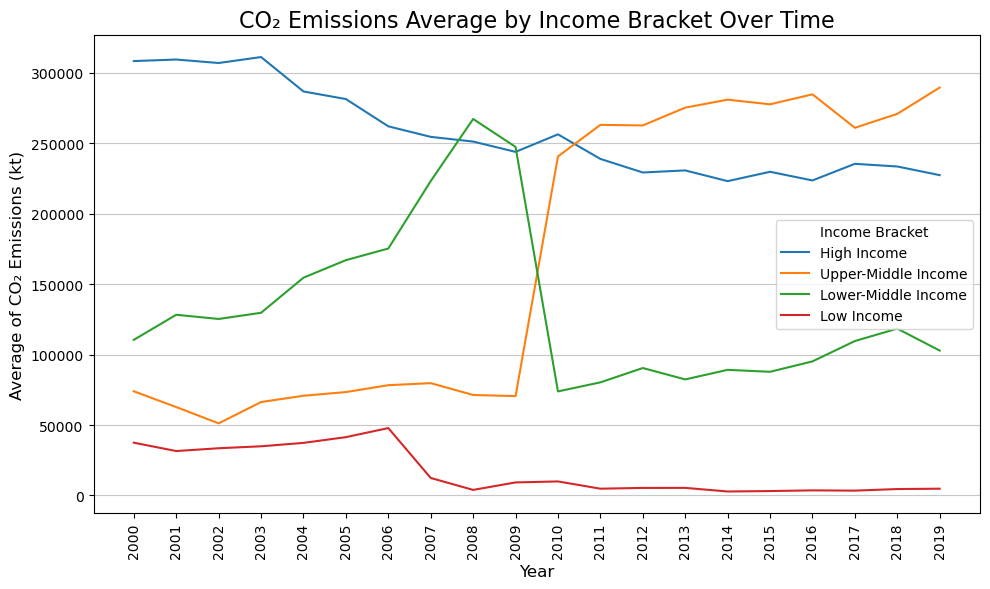

In [44]:
# Calculate the average of emissions for each year and income_bracket
emission_avg = df.groupby(['Year', 'income_bracket'], observed = True)['Value_co2_emissions_kt_by_country'].mean().reset_index()

# Plot the average of emissions
plt.figure(figsize=(10, 6))
sns.lineplot(data=emission_avg[emission_avg['Year'] != 2020], 
             x='Year', 
             y='Value_co2_emissions_kt_by_country',
             hue='income_bracket', 
             errorbar=None)

plt.title('CO₂ Emissions Average by Income Bracket Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average of CO₂ Emissions (kt)', fontsize=12)

plt.xticks(ticks=range(2000, 2020), rotation=90)

plt.grid(False)
plt.tight_layout()
plt.grid(axis='y', alpha=0.7)
plt.legend(title = 'Income Bracket')

plt.show()

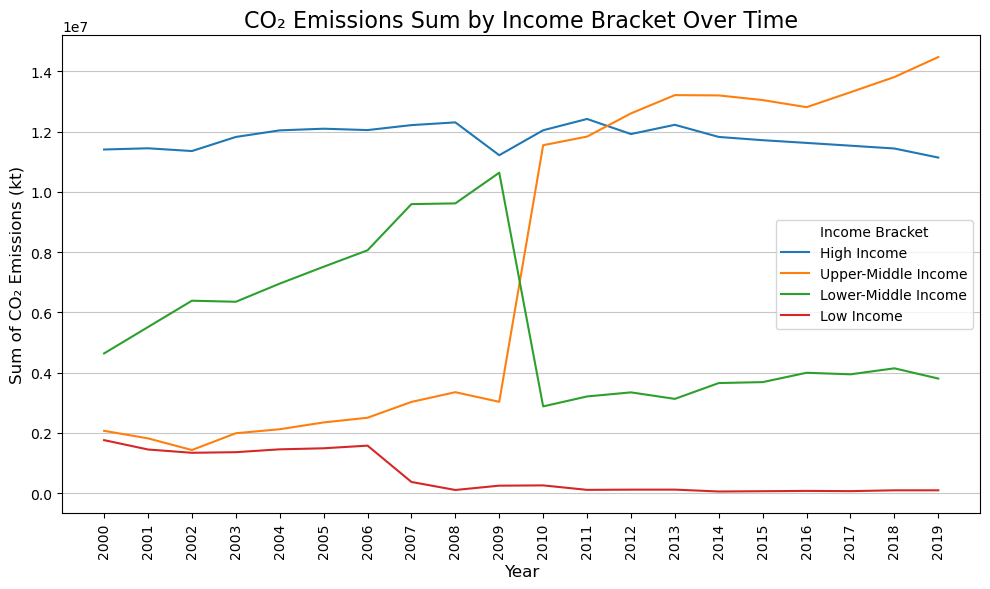

In [45]:
# Calculate the sum of emissions for each year and income_bracket
emission_sum = df.groupby(['Year', 'income_bracket'], observed = True)['Value_co2_emissions_kt_by_country'].sum().reset_index()

# Plot the sum of emissions
plt.figure(figsize=(10, 6))
sns.lineplot(data=emission_sum[emission_sum['Year'] != 2020], 
             x='Year', 
             y='Value_co2_emissions_kt_by_country',
             hue='income_bracket', 
             errorbar=None)

plt.title('CO₂ Emissions Sum by Income Bracket Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sum of CO₂ Emissions (kt)', fontsize=12)

plt.xticks(ticks=range(2000, 2020), rotation=90)

plt.grid(False)
plt.tight_layout()
plt.grid(axis='y', alpha=0.7)
plt.legend(title = 'Income Bracket')

plt.show()